Ben: A lot of unfamiliar packages here, more on the way. pipenv/virtual environments are your friend. A quick disclaimer that I am barely familiar with this domain of financial modeling, i can be very wrong in my understanding of things. i hope my code is readable.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import sleep

from pandas_datareader import data as pdr
# import pandas_ta as ta #commented out for me for now, I (Ben) had some dependency issues
import yfinance as yf
# import quandl as qd # not used, ignor ples
from backtesting import Backtest, Strategy

/home/auqdah/.local/lib/python3.7/site-packages/backtesting/_plotting.py:45: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [2]:
yf.pdr_override() # for use with pandas-datareader, optional

# Data Sources/Exploration
## which stocks/tickers will we be looking at?
We've more or less arbitrarily settled on the current S&P 500 index, a popular choice.
## What data do we need, and where can we get it?
We need OHLC (open high low close) data, on a monthly and daily scale. Using yfinance, a module that basically scrapes the ya"hoo finance site for data on tickers, we can get most of what we need.
## 

In [3]:
ticker = pd.read_csv('ticker.csv')['Ticker']
tickers = ticker.to_list() # This is a list of all tickers in the SP500
tickers = [x.replace('.','-') for x in tickers] # yahoo has '-' instead of '.' for tickers, eg BRK.B
ticker.head()

0     AAPL
1     MSFT
2     AMZN
3       FB
4    GOOGL
Name: Ticker, dtype: object

In [7]:
tickers

['AAPL',
 'MSFT',
 'AMZN',
 'FB',
 'GOOGL',
 'GOOG',
 'TSLA',
 'BRK-B',
 'JPM',
 'JNJ',
 'NVDA',
 'PYPL',
 'V',
 'DIS',
 'PG',
 'UNH',
 'MA',
 'HD',
 'BAC',
 'INTC',
 'NFLX',
 'CMCSA',
 'ADBE',
 'CRM',
 'ABT',
 'VZ',
 'XOM',
 'T',
 'WMT',
 'TMO',
 'AVGO',
 'CSCO',
 'KO',
 'PFE',
 'MRK',
 'PEP',
 'ABBV',
 'CVX',
 'NKE',
 'QCOM',
 'TXN',
 'LLY',
 'ACN',
 'MDT',
 'MCD',
 'NEE',
 'COST',
 'DHR',
 'UNP',
 'WFC',
 'HON',
 'AMGN',
 'BMY',
 'PM',
 'C',
 'LIN',
 'LOW',
 'SBUX',
 'ORCL',
 'UPS',
 'BA',
 'NOW',
 'INTU',
 'RTX',
 'AMD',
 'CAT',
 'MS',
 'AMAT',
 'GS',
 'IBM',
 'GE',
 'BLK',
 'MMM',
 'AMT',
 'DE',
 'MU',
 'TGT',
 'ISRG',
 'CVS',
 'SCHW',
 'CHTR',
 'BKNG',
 'AXP',
 'LRCX',
 'FIS',
 'LMT',
 'SPGI',
 'GILD',
 'TJX',
 'SYK',
 'MO',
 'ATVI',
 'ZTS',
 'PLD',
 'MDLZ',
 'TFC',
 'BDX',
 'CB',
 'CI',
 'ANTM',
 'PNC',
 'ILMN',
 'ADP',
 'TMUS',
 'CCI',
 'CSX',
 'CME',
 'ADSK',
 'GM',
 'CL',
 'EL',
 'USB',
 'COP',
 'NSC',
 'DUK',
 'FISV',
 'FDX',
 'ICE',
 'SO',
 'EQIX',
 'ADI',
 'GPN',
 'TWTR',


In [4]:
# sp_500 = {x:yf.Ticker(x) for x in tickers} # a dict of initialized yfinance tickers
# sp_500['AAPL'].history(start='2019-01-01', end='2020-12-31', interval='1mo')
# sp_500['AAPL'].history(start='2010-01-01', end='2020-12-31')

In [8]:
## below is how I got monthly and daily pandas dataframes of all stocks in one huge dict.  
monthly_sp500 = {}
# for tkr in tickers: # run all 500 at your own risk, it takes a while lol
for tkr in tickers[:10]:
    print('Grabbing ' + tkr + " data!")
    # monthly_sp500[tkr] = yf.Ticker(tkr).history(start='2010-01-01', end='2020-12-31', interval='1mo')
    monthly_sp500[tkr] = pdr.get_data_yahoo(tkr, start="2010-01-04", interval = "1mo")
    sleep(.1) # not planning on ddos-ing yahoo today
monthly_sp500['AAPL'] # take AAPL, for example; TODO deal with the pesky NaNs properly

Grabbing AAPL data!
[*********************100%***********************]  1 of 1 completed
Grabbing MSFT data!
[*********************100%***********************]  1 of 1 completed
Grabbing AMZN data!
[*********************100%***********************]  1 of 1 completed
Grabbing FB data!
[*********************100%***********************]  1 of 1 completed
Grabbing GOOGL data!
[*********************100%***********************]  1 of 1 completed
Grabbing GOOG data!
[*********************100%***********************]  1 of 1 completed
Grabbing TSLA data!
[*********************100%***********************]  1 of 1 completed
Grabbing BRK-B data!
[*********************100%***********************]  1 of 1 completed
Grabbing JPM data!
[*********************100%***********************]  1 of 1 completed
Grabbing JNJ data!
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-02-01,6.870357,7.327500,6.816071,7.307857,6.294721,1.077608e+10
2010-03-01,7.348214,8.481429,7.337500,8.392857,7.229299,1.215417e+10
2010-04-01,8.478929,9.730714,8.312500,9.324643,8.031907,1.236713e+10
2010-05-01,9.422857,9.567143,7.116071,9.174286,7.902396,1.808265e+10
2010-06-01,9.274643,9.964643,8.650000,8.983214,7.737815,1.665125e+10
...,...,...,...,...,...,...
2020-12-01,121.010002,138.789993,120.010002,132.690002,132.492020,2.322957e+09
2021-01-01,133.520004,145.089996,126.379997,131.960007,131.763107,2.240534e+09
2021-02-01,133.750000,137.880005,118.389999,121.260002,121.079071,1.830518e+09


In [98]:
monthly_sp500['AAPL'].loc[monthly_sp500['AAPL'].isna().any(axis=1)]

,Open,High,Low,Close,Adj Close,Volume,Name
Date,,,,,,,
2012-08-09,NaN,NaN,NaN,NaN,NaN,NaN,AAPL
2012-11-07,NaN,NaN,NaN,NaN,NaN,NaN,AAPL
2013-02-07,NaN,NaN,NaN,NaN,NaN,NaN,AAPL
2013-05-09,NaN,NaN,NaN,NaN,NaN,NaN,AAPL
2013-08-08,NaN,NaN,NaN,NaN,NaN,NaN,AAPL
2013-11-06,NaN,NaN,NaN,NaN,NaN,NaN,AAPL
2014-02-06,NaN,NaN,NaN,NaN,NaN,NaN,AAPL
2014-05-08,NaN,NaN,NaN,NaN,NaN,NaN,AAPL
2014-06-09,NaN,NaN,NaN,NaN,NaN,NaN,AAPL


In [9]:
daily_sp500 = {}
# for tkr in tickers:
for tkr in tickers[:10]: #this only gets the first 10 fyi
    print('Grabbing ' + tkr + " data!")
    # daily_sp500[tkr] = yf.Ticker(tkr).history(start='2010-01-01', end='2020-12-31', interval='1mo')
    daily_sp500[tkr] = pdr.get_data_yahoo(tkr,start="2010-01-01")
    sleep(.1)
daily_sp500['AAPL'] # take AAPL, for example

Grabbing AAPL data!
[*********************100%***********************]  1 of 1 completed
Grabbing MSFT data!
[*********************100%***********************]  1 of 1 completed
Grabbing AMZN data!
[*********************100%***********************]  1 of 1 completed
Grabbing FB data!
[*********************100%***********************]  1 of 1 completed
Grabbing GOOGL data!
[*********************100%***********************]  1 of 1 completed
Grabbing GOOG data!
[*********************100%***********************]  1 of 1 completed
Grabbing TSLA data!
[*********************100%***********************]  1 of 1 completed
Grabbing BRK-B data!
[*********************100%***********************]  1 of 1 completed
Grabbing JPM data!
[*********************100%***********************]  1 of 1 completed
Grabbing JNJ data!
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.583586,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.594968,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.490066,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.478067,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.521136,447610800
...,...,...,...,...,...,...
2021-02-22,128.009995,129.720001,125.599998,126.000000,126.000000,103607600
2021-02-23,123.760002,126.709999,118.389999,125.860001,125.860001,157859100
2021-02-24,124.940002,125.559998,122.230003,125.349998,125.349998,110691500


In [37]:
len(monthly_sp500['AAPL'].loc[monthly_sp500['AAPL'].isna().any(axis=1)])/len(monthly_sp500['AAPL']) * 100 #percentage of missingness

21.637426900584796

In [48]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors = 2)


imputed_aapl = imputer.fit_transform(monthly_sp500['AAPL'].drop('Name', axis=1))
imputed_aapl = pd.DataFrame(imputed_aapl,columns=['Open','High','Low','Close','Adj Close','Volume'])

In [55]:
imputed_aapl = imputed_aapl.set_index(monthly_sp500['AAPL'].index)

In [53]:
len(imputed_aapl.loc[imputed_aapl.isna().any(axis=1)])/len(imputed_aapl) * 100 #percentage of missingness

0.0

In [10]:
# everything in one stupid large dataframe
sp500m = monthly_sp500[tickers[0]] # monthly
sp500m['Name'] = tickers[0]

sp500d = daily_sp500[tickers[0]] # daily
sp500d['Name'] = tickers[0]

# for tkr in tickers[1:10]:
for tkr in tickers:
    df1 = monthly_sp500[tkr] # monthly
    df1['Name'] = tkr
    # df.set_index(['Name','Date'],inplace=True)
    sp500m = sp500_m.append(df1)

    df2 = daily_sp500[tkr] # daily
    df2['Name'] = tkr
    # df.set_index(['Name','Date'],inplace=True)
    sp500d = sp500_d.append(df2)
sp500m

NameError: name 'sp500_m' is not defined

In [ ]:
sp500m

In [ ]:
print(sp500m.shape,sp500d.shape)
sp500d

In [ ]:
# sp500m.to_csv('SP500_monthly.csv')
# sp500d.to_csv('SP500_daily.csv')
# pd.read_csv('SP500_monthly.csv').head()

## ----prototyping below----

In [56]:
aapl = imputed_aapl # take a look at apple again, this time with no nulls (dont know how to deal with them help)
aapl.dropna()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-02-01,6.870357,7.327500,6.816071,7.307857,6.294721,1.077608e+10
2010-03-01,7.348214,8.481429,7.337500,8.392857,7.229299,1.215417e+10
2010-04-01,8.478929,9.730714,8.312500,9.324643,8.031907,1.236713e+10
2010-05-01,9.422857,9.567143,7.116071,9.174286,7.902396,1.808265e+10
2010-06-01,9.274643,9.964643,8.650000,8.983214,7.737815,1.665125e+10
...,...,...,...,...,...,...
2020-12-01,121.010002,138.789993,120.010002,132.690002,132.492020,2.322957e+09
2021-01-01,133.520004,145.089996,126.379997,131.960007,131.763107,2.240534e+09
2021-02-01,133.750000,137.880005,118.389999,121.260002,121.079071,1.830518e+09


In [230]:
from sklearn.impute import KNNImputer

def effect(x):
    if( x < 0.0 ):
        return "Reversal"
    elif(x > 0.0):
        return "Momentum"
    else:
        return "None"
    


## shamelessly stolen code, still trying to comprehend what wizardry is going on in here
dfs = []
k = 4
imputer = KNNImputer(n_neighbors = 2)
for ticker in tickers[:10]:
    print('Grabbing ' + ticker + " data!")
    curr_df = pdr.get_data_yahoo(ticker, start="2009-12-01", interval = "1mo")
    if(curr_df.empty):
        print('Failed to get ' + ticker + ' stock data!')
        continue
    
    #imputed_df = imputer.fit_transform(curr_df)
    #imputed_df = pd.DataFrame(imputed_df,columns=['Open','High','Low','Close','Adj Close','Volume'])
    #imputed_df = imputed_df.set_index(curr_df.index)
    
    
    curr_df = curr_df.dropna()
    #imputed_df['Name'] = ticker
    curr_df['Name'] = ticker
    curr_df = imputed_df
    print(curr_df.isna().sum())
    curr_df = curr_df.reset_index()
    curr_df.set_index(['Name','Date'],inplace=True)
    curr_df = curr_df[~curr_df.index.duplicated(keep='first')]
    obs_df = (curr_df.reset_index(level=[0])
              ['Adj Close'].resample(str(k) + 'M').first().ffill().pct_change()[1:]).to_frame()
    obs_df.rename(columns={'Adj Close':'Adj Close %Change'},inplace=True)
    obs_df['Name'] = ticker
    obs_df = obs_df.reset_index()
    obs_df.set_index(['Name','Date'],inplace=True)
    obs_df['Cum Returns'] = (obs_df['Adj Close %Change'] + 1).groupby('Name').cumprod()
    obs_df['Effect'] = obs_df['Adj Close %Change'].apply(effect)
    dfs.append(obs_df)
    curr_df = None
    obs_df = None

Grabbing AAPL data!
[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Name         0
dtype: int64
Grabbing MSFT data!
[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Name         0
dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Grabbing AMZN data!
[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Name         0
dtype: int64
Grabbing FB data!
[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Name         0
dtype: int64
Grabbing GOOGL data!
[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Name         0
dtype: int64
Grabbing GOOG data!
[*********************100%***********************]  1 of 1 completed


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Name         0
dtype: int64
Grabbing TSLA data!
[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Name         0
dtype: int64
Grabbing BRK-B data!
[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Name         0
dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Grabbing JPM data!
[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Name         0
dtype: int64
Grabbing JNJ data!


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[*********************100%***********************]  1 of 1 completed
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Name         0
dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


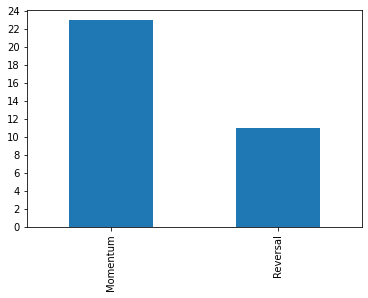

In [231]:
dfs[8]['Effect'].value_counts().plot(kind='bar',yticks=range(0,25,2))

In [232]:
new_df = pd.merge_asof(dfs[0],aapl,on='Date')
new_df['Name'] = 'AAPL'
new_df.set_index(['Name','Date'],inplace=True)
new_df = new_df[~new_df.index.duplicated(keep='first')]
new_df

Adj Close %Change  Cum Returns    Effect        Open  \
Name Date                                                               
AAPL 2010-04-30          -0.024065     0.975935  Reversal    8.478929   
     2010-08-31          -0.065446     0.912065  Reversal    9.301429   
     2010-12-31           0.082600     0.987401  Momentum   11.259643   
     2011-04-30          -0.027044     0.960698  Reversal   12.539643   
     2011-08-31           0.135997     1.091350  Momentum   14.206429   
     2011-12-31          -0.036785     1.051205  Reversal   13.662143   
     2012-04-30           0.044460     1.097942  Momentum   21.493929   
     2012-08-31          -0.044433     1.049157  Reversal   35.666607   
     2012-12-31           0.124670     1.179955  Momentum   21.201786   
     2013-04-30           0.082189     1.276935  Momentum   15.782143   
     2013-08-31           0.147908     1.465804  Momentum   35.666607   
     2013-12-31           0.045376     1.532316  Momentum   19.928572   
     2014-04-30           0.027658     1.574696  Momentum   19.205713   
     2014-08-31           0.155082     1.818902  Momentum   35.666607   
     2014-12-31           0.065039     1.937202  Momentum   29.702499   
     2015-04-30          -0.054394     1.831830  Reversal   31.205000   
     2015-08-31           0.007000     1.844654  Momentum   35.666607   
     2015-12-31          -0.053824     1.745366  Reversal   29.687500   
     2016-04-30           0.127048     1.967111  Momentum   27.195000   
     2016-08-31           0.086812     2.137880  Momentum   35.666607   
     2016-12-31           0.062802     2.272143  Momentum   27.592501   
     2017-04-30          -0.034686     2.193332  Reversal   35.927502   
     2017-08-31           0.139944     2.500275  Momentum   35.666607   
     2017-12-31           0.026937     2.567625  Momentum   42.487499   
     2018-04-30           0.069428     2.745888  Momentum   41.660000   
     2018-08-31          -0.128837     2.392115  Reversal   35.666607   
     2018-12-31           0.171396     2.802114  Momentum   46.115002   
     2019-04-30          -0.030705     2.716075  Reversal   47.910000   
     2019-08-31          -0.007967     2.694437  Reversal   35.666607   
     2019-12-31           0.000697     2.696315  Momentum   66.817497   
     2020-04-30           0.158613     3.123986  Momentum   61.625000   
     2020-08-31           0.005566     3.141373  Momentum   35.666607   
     2020-12-31           0.014520     3.186985  Momentum  121.010002   
     2021-04-30           0.103329     3.516292  Momentum  122.589996   

                       High         Low       Close   Adj Close        Volume  
Name Date                                                                      
AAPL 2010-04-30    9.730714    8.312500    9.324643    8.031907  1.236713e+10  
     2010-08-31    9.438571    8.412857    8.682143    7.478480  9.589121e+09  
     2010-12-31   11.666429   11.246071   11.520000    9.922909  6.973235e+09  
     2011-04-30   12.683214   11.434286   12.504643   10.771044  9.253829e+09  
     2011-08-31   14.267857   12.607857   13.743929   11.838518  1.614260e+10  
     2011-12-31   14.610357   13.488571   14.464286   12.459009  6.306532e+09  
     2012-04-30   23.000000   19.821428   20.856428   17.964962  1.559899e+10  
     2012-08-31   38.327353   33.587836   36.323057   34.606373  5.841127e+09  
     2012-12-31   21.235357   17.901072   19.006071   16.516520  1.213275e+10  
     2013-04-30   15.901786   13.753571   15.813571   13.822287  1.096349e+10  
     2013-08-31   38.327353   33.587836   36.323057   34.606373  5.841127e+09  
     2013-12-31   20.540714   19.242857   20.036428   17.849323  7.057397e+09  
     2014-04-30   21.408215   18.261786   21.074642   18.886589  6.435061e+09  
     2014-08-31   38.327353   33.587836   36.323057   34.606373  5.841127e+09  
     2014-12-31   29.812500   26.565001   27.594999   25.100164  4.294378e+09  
     2015-04-30   33.634998 

In [233]:
import pandas_ta as ta
new_df.ta.cores = 4
new_df.ta.sma(length=8, append=True)
new_df.ta.rsi(append=True)
new_df.ta.cci(length=8, append=True)
new_df['return std'] = new_df['Cum Returns'].rolling(2).std()
new_df.ta.willr(length=k/2, append=True)
new_df.ta.roc(length=k/2,append=True)
new_df.ta.ema(append=True)
new_df.ta.pdist(append=True)
new_df.ta.variance(length=4,append=True)
new_df.ta.psar(append=True)
new_df = new_df.join(pd.get_dummies(new_df.Effect, prefix='Effect')) #one hot
new_df

Adj Close %Change  Cum Returns    Effect        open  \
Name Date                                                               
AAPL 2010-04-30          -0.024065     0.975935  Reversal    8.478929   
     2010-08-31          -0.065446     0.912065  Reversal    9.301429   
     2010-12-31           0.082600     0.987401  Momentum   11.259643   
     2011-04-30          -0.027044     0.960698  Reversal   12.539643   
     2011-08-31           0.135997     1.091350  Momentum   14.206429   
     2011-12-31          -0.036785     1.051205  Reversal   13.662143   
     2012-04-30           0.044460     1.097942  Momentum   21.493929   
     2012-08-31          -0.044433     1.049157  Reversal   35.666607   
     2012-12-31           0.124670     1.179955  Momentum   21.201786   
     2013-04-30           0.082189     1.276935  Momentum   15.782143   
     2013-08-31           0.147908     1.465804  Momentum   35.666607   
     2013-12-31           0.045376     1.532316  Momentum   19.928572   
     2014-04-30           0.027658     1.574696  Momentum   19.205713   
     2014-08-31           0.155082     1.818902  Momentum   35.666607   
     2014-12-31           0.065039     1.937202  Momentum   29.702499   
     2015-04-30          -0.054394     1.831830  Reversal   31.205000   
     2015-08-31           0.007000     1.844654  Momentum   35.666607   
     2015-12-31          -0.053824     1.745366  Reversal   29.687500   
     2016-04-30           0.127048     1.967111  Momentum   27.195000   
     2016-08-31           0.086812     2.137880  Momentum   35.666607   
     2016-12-31           0.062802     2.272143  Momentum   27.592501   
     2017-04-30          -0.034686     2.193332  Reversal   35.927502   
     2017-08-31           0.139944     2.500275  Momentum   35.666607   
     2017-12-31           0.026937     2.567625  Momentum   42.487499   
     2018-04-30           0.069428     2.745888  Momentum   41.660000   
     2018-08-31          -0.128837     2.392115  Reversal   35.666607   
     2018-12-31           0.171396     2.802114  Momentum   46.115002   
     2019-04-30          -0.030705     2.716075  Reversal   47.910000   
     2019-08-31          -0.007967     2.694437  Reversal   35.666607   
     2019-12-31           0.000697     2.696315  Momentum   66.817497   
     2020-04-30           0.158613     3.123986  Momentum   61.625000   
     2020-08-31           0.005566     3.141373  Momentum   35.666607   
     2020-12-31           0.014520     3.186985  Momentum  121.010002   
     2021-04-30           0.103329     3.516292  Momentum  122.589996   

                       high         low       close   adj_close        volume  \
Name Date                                                                       
AAPL 2010-04-30    9.730714    8.312500    9.324643    8.031907  1.236713e+10   
     2010-08-31    9.438571    8.412857    8.682143    7.478480  9.589121e+09   
     2010-12-31   11.666429   11.246071   11.520000    9.922909  6.973235e+09   
     2011-04-30   12.683214   11.434286   12.504643   10.771044  9.253829e+09   
     2011-08-31   14.267857   12.607857   13.743929   11.838518  1.614260e+10   
     2011-12-31   14.610357   13.488571   14.464286   12.459009  6.306532e+09   
     2012-04-30   23.000000   19.821428   20.856428   17.964962  1.559899e+10   
     2012-08-31   38.327353   33.587836   36.323057   34.606373  5.841127e+09   
     2012-12-31   21.235357   17.901072   19.006071   16.516520  1.213275e+10   
     2013-04-30   15.901786   13.753571   15.813571   13.822287  1.096349e+10   
     2013-08-31   38.327353   33.587836   36.323057   34.606373  5.841127e+09   
     2013-12-31   20.540714   19.242857   20.036428   17.849323  7.057397e+09   
     2014-04-30   21.408215   18.261786   21.074642   18.886589  6.435061e+09   
     2014-08-31   38.327353   33.587836   36.323057   34.606373  5.841127e+09   
     2014-12-31   29.812500   26.565001   27.594999   25.100164  4.294378e+09   
     2015-0

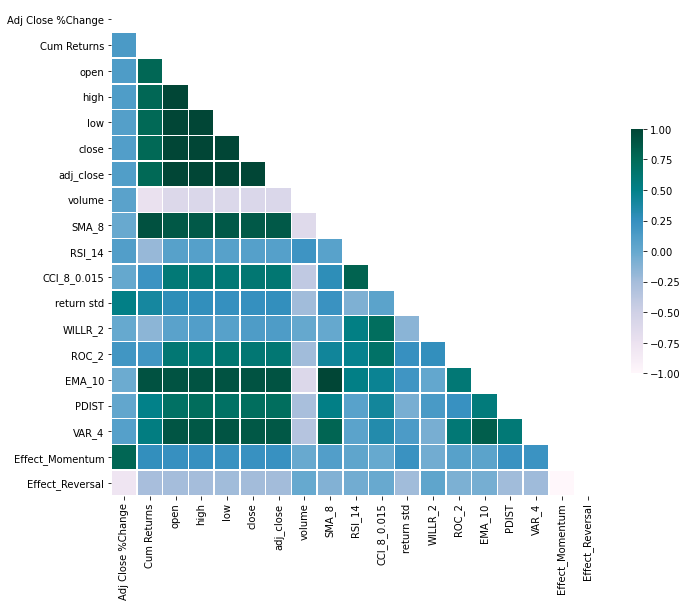

In [229]:
import seaborn as sns

corr = new_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap="PuBuGn", vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [202]:
new_df

Adj Close %Change  Cum Returns    Effect        open  \
Name Date                                                               
AAPL 2010-04-30          -0.024065     0.975935  Reversal    8.478929   
     2010-08-31          -0.065446     0.912065  Reversal    9.301429   
     2010-12-31           0.082600     0.987401  Momentum   11.259643   
     2011-04-30          -0.027044     0.960698  Reversal   12.539643   
     2011-08-31           0.135997     1.091350  Momentum   14.206429   
     2011-12-31          -0.036785     1.051205  Reversal   13.662143   
     2012-04-30           0.044460     1.097942  Momentum   21.493929   
     2012-08-31          -0.044433     1.049157  Reversal   35.666607   
     2012-12-31           0.124670     1.179955  Momentum   21.201786   
     2013-04-30           0.082189     1.276935  Momentum   15.782143   
     2013-08-31           0.147908     1.465804  Momentum   35.666607   
     2013-12-31           0.045376     1.532316  Momentum   19.928572   
     2014-04-30           0.027658     1.574696  Momentum   19.205713   
     2014-08-31           0.155082     1.818902  Momentum   35.666607   
     2014-12-31           0.065039     1.937202  Momentum   29.702499   
     2015-04-30          -0.054394     1.831830  Reversal   31.205000   
     2015-08-31           0.007000     1.844654  Momentum   35.666607   
     2015-12-31          -0.053824     1.745366  Reversal   29.687500   
     2016-04-30           0.127048     1.967111  Momentum   27.195000   
     2016-08-31           0.086812     2.137880  Momentum   35.666607   
     2016-12-31           0.062802     2.272143  Momentum   27.592501   
     2017-04-30          -0.034686     2.193332  Reversal   35.927502   
     2017-08-31           0.139944     2.500275  Momentum   35.666607   
     2017-12-31           0.026937     2.567625  Momentum   42.487499   
     2018-04-30           0.069428     2.745888  Momentum   41.660000   
     2018-08-31          -0.128837     2.392115  Reversal   35.666607   
     2018-12-31           0.171396     2.802114  Momentum   46.115002   
     2019-04-30          -0.030705     2.716075  Reversal   47.910000   
     2019-08-31          -0.007967     2.694437  Reversal   35.666607   
     2019-12-31           0.000697     2.696315  Momentum   66.817497   
     2020-04-30           0.158613     3.123986  Momentum   61.625000   
     2020-08-31           0.005566     3.141373  Momentum   35.666607   
     2020-12-31           0.014520     3.186985  Momentum  121.010002   
     2021-04-30           0.103329     3.516292  Momentum  122.589996   

                       high         low       close   adj_close        volume  \
Name Date                                                                       
AAPL 2010-04-30    9.730714    8.312500    9.324643    8.031907  1.236713e+10   
     2010-08-31    9.438571    8.412857    8.682143    7.478480  9.589121e+09   
     2010-12-31   11.666429   11.246071   11.520000    9.922909  6.973235e+09   
     2011-04-30   12.683214   11.434286   12.504643   10.771044  9.253829e+09   
     2011-08-31   14.267857   12.607857   13.743929   11.838518  1.614260e+10   
     2011-12-31   14.610357   13.488571   14.464286   12.459009  6.306532e+09   
     2012-04-30   23.000000   19.821428   20.856428   17.964962  1.559899e+10   
     2012-08-31   38.327353   33.587836   36.323057   34.606373  5.841127e+09   
     2012-12-31   21.235357   17.901072   19.006071   16.516520  1.213275e+10   
     2013-04-30   15.901786   13.753571   15.813571   13.822287  1.096349e+10   
     2013-08-31   38.327353   33.587836   36.323057   34.606373  5.841127e+09   
     2013-12-31   20.540714   19.242857   20.036428   17.849323  7.057397e+09   
     2014-04-30   21.408215   18.261786   21.074642   18.886589  6.435061e+09   
     2014-08-31   38.327353   33.587836   36.323057   34.606373  5.841127e+09   
     2014-12-31   29.812500   26.565001   27.594999   25.100164  4.294378e+09   
     2015-0

# Modeling:
Below we start to really look at feature engineering, not much here yet

In [ ]:
def features(ticker_df):
    #
    returns  = ticker_df['Adj Close'].resample('M').ffill().pct_change() 
    cum_returns = (returns + 1).cumprod()
    cum_returns

In [ ]:
# pd.read_csv('constituent_performance_4_months.csv')

In [ ]:
# momentum/ model: given a huge dataset with daily/monthly data, we determine in an initial period J to find which tickers do the best/worst, 

## ---notes below---

# For the momentum analysis portion:
The way we plan to proceed for now is to give each stock in our index (sp500) equal weights, in a sense, then rank them by some criteria on how well they are performing. we will adopt the observe J and hold K strategy as detailed in the paper, in which there is an observatory period of J quarters/months/days and a holding period of K quarters/months/days (Ben: idk, j might be able to overlap with k, we can do a lot with how we implement it). In short, we classify in the J period whether a particular ticker would be best treated with a momentum or reversal strategy, or some other. The classification task here is thus presented.

momentum strategy: buy/give heavier weights over time to well performing stocks, as we assume they will continue to get better as per our understanding of momentum

reversal strategy: Amir proposed we short underperforming stocks. This strategy we adopt *might* actually be different from what the paper is proposing, which is to buy and hold underperforming stocks as we predict it to rebound (Ben: fact check me pls).

stocks in between: dont buy them, or leave them as they are...? feel free to share your own thoughts.

# For the modeling portion: 
a lot still left untouched, ill think a bit harder about it tmr ...
we want 3 models to do this kind of momentum analysis algorithmically vs manually, and pit it against a baseline of a simple buy and hold strategy. The parameters will come from a wealth of technical analysis (read: all the fancy hard to understand financial forecasting stuff) libraries already available (we probably wont be making most of them, beyond the simple stuff) but we do have a deadline to keep in mind.